# Lab 4 - BCC406/PCC177

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Uso de Framework (TensorFlow) e K-Fold

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Classificação utilizando TensorFlow.
- Regressão Logística.
- Cálculos de métircas

Data da entrega : 04/02

- Complete o código (marcado com 'ToDo') e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-LabX.pdf"
- Envie o PDF via google [FORM](https://forms.gle/mNuPE4qRtDLFUg6e8)
- Envie o *.ipynb* também.



# Preparação do ambiente e Tratamento dos dados

## Preparação do ambiente

### Importação das bibliotecas

Primeiro precisamos importar os pacotes. Vamos executar a célula abaixo para importar todos os pacotes que precisaremos.
- [*TensorFlow*](https://www.tensorflow.org/?hl=pt-br) é o pacote fundamental de operações de *Deep Learning*.
- [*numpy*](www.numpy.org) é o pacote fundamental para a computação científica com Python.
- [*h5py*](http://www.h5py.org) é um pacote comum para interagir com um conjunto de dados armazenado em um arquivo H5.
- [*matplotlib*](http://matplotlib.org) é uma biblioteca famosa para plotar gráficos em Python.
- [*PIL*](http://www.pythonware.com/products/pil/) e [*scipy*](https://www.scipy.org/) são usados aqui para carregar as imagens e testar seu modelo final.
- [*Scikit Learn*](https://scikit-learn.org/) é um pacote muito utilizado para treinamento de modelos e outros algoritmos de *machine learning*.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

from sklearn.metrics import accuracy_score
import tensorflow as tf

from tensorflow import keras

### Configurando os *plots* de gráficos

O próximo passo é configurar o *matplotlib* e a geração de valores aleatórios.

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configurando o Google Colab.

Configurando o Google Colab para acessar os nossos dados.

In [ ]:
# Você vai precisar fazer o upload dos arquivos no seu drive (faer na pasta raiz) e montá-lo
# não se esqueça de ajustar o path para o seu drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregando e préprocessamento dos dados

In [ ]:
# Função para ler os dados (gato/não-gato)
def load_dataset():
    def _load_data():
      train_dataset = h5py.File('/content/drive/MyDrive/treino_teste/train_catvnoncat.h5', "r")
      train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
      train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

      test_dataset = h5py.File('/content/drive/MyDrive/treino_teste/test_catvnoncat.h5', "r")
      test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
      test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

      classes = np.array(test_dataset["list_classes"][:]) # the list of classes
      train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
      test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

      return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

    def _preprocess_dataset(_treino_x_orig, _teste_x_orig):
      # Formate o conjunto de treinamento e teste dados de treinamento e teste para que as imagens
      # de tamanho (num_px, num_px, 3) sejam vetores de forma (num_px * num_px * 3, 1)
      print(_treino_x_orig.shape)
      print(_teste_x_orig.shape)
      #_treino_x_orig = _treino_x_orig.reshape(_treino_x_orig.shape[0], 64 * 64 * 3)
      #_teste_x_orig = _teste_x_orig.reshape(_teste_x_orig.shape[0], 64 * 64 * 3)
      _treino_x_vet = _treino_x_orig.reshape(_treino_x_orig.shape[0], -1) # ToDo: vetorizar os dados de treinamento aqui
      _teste_x_vet = _teste_x_orig.reshape(_teste_x_orig.shape[0], -1) # ToDo: vetorizar os dados de teste aqui

      # Normalize os dados (colocar no intervalo [0.0, 1.0])
      _treino_x = _treino_x_vet/255. # ToDo: normalize os dados de treinamento aqui
      _teste_x = _teste_x_vet/255. # ToDo: normalize os dados de teste aqui
      return _treino_x, _teste_x

    treino_x_orig, treino_y, teste_x_orig, teste_y, classes = _load_data()
    treino_x, teste_x = _preprocess_dataset(treino_x_orig, teste_x_orig)
    return treino_x, treino_y, teste_x, teste_y, classes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Carregando os dados

In [ ]:
# Lendo os dados (gato/não-gato)
treino_x, treino_y, teste_x, teste_y, classes = load_dataset()


(209, 64, 64, 3)
(50, 64, 64, 3)


# Treinamento do modelo (100pt)

Há diversos frameworks para criação de modelos de *deep learning*, como [TensorFlow](https://www.tensorflow.org/) e [PyTorch](https://pytorch.org/). Nesta prática, usaremos o TensorFlow.


### Função para treinar um modelo

A primeira parte envolve a criação de uma função que será usada para treinar os próximos modelos. Essa função será usada em todos os modelos testados.

In [ ]:
def treinar_modelo(modelo, treino_x, treino_y, epochs=100):
    # Setando a seed
    np.random.seed(1)

    # Compilando o modelo
    modelo.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                   )

    # Imprimindo a arquitetura da rede proposta
    modelo.summary()

    # Treinando o modelo
    modelo.fit(treino_x, treino_y.reshape(-1), epochs=epochs)
    return modelo

## Modelo 1: Testando um modelo com uma camada oculta com 8 neurônios (10pt)

Definição de um modelo com uma camada oculta (8 neurônios) e uma camada de saída com um neurônio (gato e não gato). Usaremos a ativação ReLU (*Retified Linear Unity*) na camada oculta e a *sigmoid* na camada de saída. Para classificação de classes 0 ou 1, pode-se ter um único neurônio de saída e deve-se usar a operação sigmoid antes de se calcular o custo (mean-squared error ou binary cross entropy).

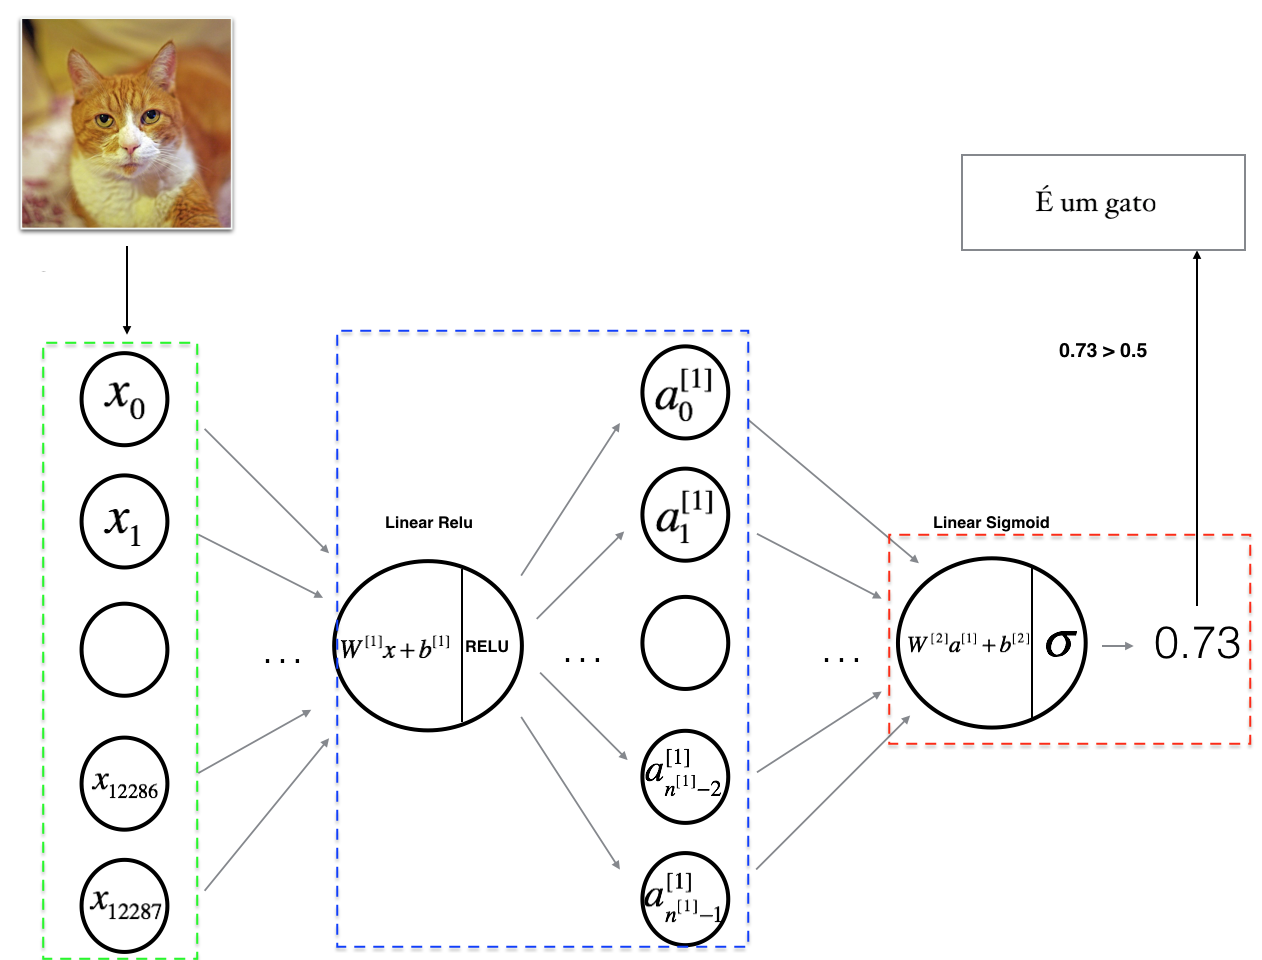
<caption><center> <u>Figura 1</u>: Rede neural com 2 camadas. <br> Resumo do modelo: ***ENTRADA -> LINEAR -> RELU -> LINEAR -> SIGMOID -> SAIDA***. </center></caption>

<!--
<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$.
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias).
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.
!-->

### Definição do modelo (5pt)

A primeira etapa é a definição da arquitetura do modelo. Para este primeiro modelo será usado um modelo com somente oito neurônios.

In [ ]:
# Definição do modelo
def modelo_1():
  _model = tf.keras.models.Sequential() # Crie um modelo sequencial com keras.Sequential
  _model.add(tf.keras.layers.Dense(8,activation = 'relu')) # ToDo: Adicione uma camada densa com 8 neurônios e ativação relu
  _model.add(tf.keras.layers.Dense(1,activation = 'sigmoid')) # ToDo: Adicione uma camada densa com 1 neurônio e ativação sigmoid **dica** use a classe keras.layers.Dense
  return _model

### Instanciando o modelo e testando (5pt)

Treine o modelo e depois **use os parâmetros treinados** para classificar as imagens de treinamento e teste e verificar a acurácia.

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

# Criando o modelo
m1 = modelo_1() # ToDo: chame a função que define o modelo
# Treinando o modelo
m1 = treinar_modelo(m1, treino_x, treino_y) # ToDo: Chame a função para treinar o modelo

previsoes_treino = np.round(m1.predict(treino_x))
previsoes_test = np.round(m1.predict(teste_x))

## Predição da rede
print(f'\n\nAcurácia no treino: {accuracy_score(treino_y.reshape(-1), previsoes_treino)}') # ToDo: Utilize a função accuracy_score do sklearn para calcular a acurácia nos dados de treino
                                         # **dica** use o model.predict para predizer os dados e use o reshape com -1 nos labels
print(f'Acurácia no teste: {accuracy_score(teste_y.reshape(-1), previsoes_test)}') # ToDo: Utilize a função accuracy_score do sklearn para calcular a acurácia nos dados de teste
                                    # **dica** use o model.predict para predizer os dados e use o reshape com -1 nos labels

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5485 - loss: 1.0090
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4043 - loss: 0.6932  
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6609 - loss: 0.6926 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6609 - loss: 0.6919
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6609 - loss: 0.6910
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6609 - loss: 0.6901
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6609 - loss: 0.6891
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6609 - loss: 0.6882
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6609 - loss: 0.6873
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6609 - loss: 0.6864
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6609 - loss: 0.6855 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6609 - l

**Resultado esperado:** (pode ser diferente)

```
  Acurácia treino = 81.34%
  Acurácia teste = 52.00%
```

## Modelo 2: Testando um modelo com uma camada oculta com 256 neurônios (15pt)

### Definição do modelo (10pt)

In [ ]:
# Definição do modelo
def modelo_2():
  _model = tf.keras.models.Sequential() # Crie um modelo sequencial com keras.Sequential
  _model.add(tf.keras.layers.Dense(256,activation = 'relu')) # ToDo: Adicione uma camada densa com 8 neurônios e ativação relu
  _model.add(tf.keras.layers.Dense(1,activation = 'sigmoid')) # ToDo: Adicione uma camada densa com 1 neurônio e ativação sigmoid **dica** use a classe keras.layers.Dense
  return _model

Crie um modelo com uma camada oculta (256 neurônios e ativação ReLu) e a camada de saída com um neurônio (ativação sigmoid).

Agora treine e teste o seu modelo.

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

# Criando o modelo
m2 = modelo_2() # ToDo: chame a função que define o modelo
# Treinando o modelo
m2 = treinar_modelo(m2, treino_x, treino_y) # ToDo: Chame a função para treinar o modelo

previsoes_treino = np.round(m2.predict(treino_x))
previsoes_test = np.round(m2.predict(teste_x))

## Predição da rede
print(f'\n\nAcurácia no treino: {accuracy_score(treino_y.reshape(-1), previsoes_treino)}') # ToDo: Utilize a função accuracy_score do sklearn para calcular a acurácia nos dados de treino
                                         # **dica** use o model.predict para predizer os dados e use o reshape com -1 nos labels
print(f'Acurácia no teste: {accuracy_score(teste_y.reshape(-1), previsoes_test)}') # ToDo: Utilize a função accuracy_score do sklearn para calcular a acurácia nos dados de teste
                                    # **dica** use o model.predict para predizer os dados e use o reshape com -1 nos labels

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6173 - loss: 4.8643
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6609 - loss: 2.4995
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5578 - loss: 1.0149
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6717 - loss: 1.0337
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6154 - loss: 0.6719
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6700 - loss: 0.7114
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5728 - loss: 0.6617
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.6945 - loss: 0.5489
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7020 - loss: 0.5595
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7299 - loss: 0.5291
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7755 - loss: 0.4967
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7671 - lo

**Resultado esperado:** (pode ser diferente)

```
  Acurácia treino = 100.00%
  Acurácia teste = 70%
```

### Análise dos resultados (5pt)

**ToDo:** Por que você obteve 100% no treino e apenas 80% no teste no segundo modelo e resultados piores no primeiro modelo?

```
Isso pode acontecer por causa do overfitting, o segundo modelo aprendeu muito bem os padrões dos dados de treino, com isso o desempenho no treino fica perfeito, quando joga dados novos pra testar ele n consegue manter a mesma precisão. Já o primeiro modelo teve um desempenho pior porque talvez sua arquitetura fosse muito simples e incapaz de capturar padrões mais complexos nos dados.
```

## Modelo 3: Testando com uma rede com três camadas ocultas (15pt)

### Definição do modelo (10pt)

In [ ]:
# Definição do modelo
def modelo_3():
  _model = tf.keras.models.Sequential() # Crie um modelo sequencial com keras.Sequential
  _model.add(tf.keras.layers.Dense(256,activation = 'relu')) # ToDo: Adicione uma camada densa com 8 neurônios e ativação relu
  _model.add(tf.keras.layers.Dense(64,activation = 'relu')) # ToDo: Adicione uma camada densa com 8 neurônios e ativação relu
  _model.add(tf.keras.layers.Dense(8,activation = 'relu')) # ToDo: Adicione uma camada densa com 8 neurônios e ativação relu
  _model.add(tf.keras.layers.Dense(1,activation = 'sigmoid')) # ToDo: Adicione uma camada densa com 1 neurônio e ativação sigmoid **dica** use a classe keras.layers.Dense

  return _model

Crie um modelo com três camadas ocultas e a camada de saída com um neurônio.
Você deve seguir a seguinte estrutura:
1. Camada oculta 1 - 256 neurônios e ativação ReLU.
2. Camada oculta 2 - 64 neurônios e ativação ReLU.
3. Camada oculta 3 - 8 neurônios e ativação ReLU.
4. Camada de saída - 1 neurônio e ativação sigmoid.

Agora treine e teste o seu modelo.

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

# Criando o modelo
m3 = modelo_3() # ToDo: chame a função que define o modelo
# Treinando o modelo
m3 = treinar_modelo(m3, treino_x, treino_y) # ToDo: Chame a função para treinar o modelo

previsoes_treino = np.round(m3.predict(treino_x))
previsoes_test = np.round(m3.predict(teste_x))

## Predição da rede
print(f'\n\nAcurácia no treino: {accuracy_score(treino_y.reshape(-1), previsoes_treino)}') # ToDo: Utilize a função accuracy_score do sklearn para calcular a acurácia nos dados de treino
                                         # **dica** use o model.predict para predizer os dados e use o reshape com -1 nos labels
print(f'Acurácia no teste: {accuracy_score(teste_y.reshape(-1), previsoes_test)}') # ToDo: Utilize a função accuracy_score do sklearn para calcular a acurácia nos dados de teste
                                    # **dica** use o model.predict para predizer os dados e use o reshape com -1 nos labels

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5772 - loss: 1.7127
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6502 - loss: 0.7955
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6079 - loss: 1.1520
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6216 - loss: 0.8727
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6605 - loss: 0.7479
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6220 - loss: 0.7171
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6278 - loss: 0.6776
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6979 - loss: 0.5801
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7479 - loss: 0.5214
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7809 - loss: 0.5086
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7669 - loss: 0.4996
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7690 - lo

**Resultado esperado:**

```
  Acurácia treino = 100.00%
  Acurácia teste = 76%
```

### Análise dos resultados (5pt)

**ToDo:**  O resultado com três camadas ocultas foi melhor ou pior do que usa somente uma camada? Tente explicar os motivos.


```
O desempenho com três camadas ocultas foi pior, talvez o problema tenha sido o overfitting, pois com mais camadas e parâmetros, a rede pode ter aprendido padrões específicos de dados de treino em vez de generalizar para novos exmplos. E redes mais profundas exigem um volume maior de dados para treinar adequadamente. Se os dados disponíveis n forem suficientes, a rede pode acabar ajudatando demais ao conjunto de treino e ter um desempenho pior no teste.  
```

## Testando uma rede que você desenvolveu (15pt)

Crie uma arquitetura e treine/teste o seu modelo

### Definição do modelo (10pt)

In [ ]:
# Definição do modelo
def meu_modelo():
  _model = tf.keras.models.Sequential() # Crie um modelo sequencial com keras.Sequential
  _model.add(tf.keras.layers.Dense(256,activation = 'relu')) # ToDo: Adicione uma camada densa com 8 neurônios e ativação relu
  _model.add(tf.keras.layers.Dense(64,activation = 'relu')) # ToDo: Adicione uma camada densa com 8 neurônios e ativação relu
  _model.add(tf.keras.layers.Dense(64,activation = 'relu')) # ToDo: Adicione uma camada densa com 8 neurônios e ativação relu
  _model.add(tf.keras.layers.Dense(64,activation = 'relu')) # ToDo: Adicione uma camada densa com 8 neurônios e ativação relu
  _model.add(tf.keras.layers.Dense(8,activation = 'relu')) # ToDo: Adicione uma camada densa com 8 neurônios e ativação relu
  _model.add(tf.keras.layers.Dense(1,activation = 'sigmoid')) # ToDo: Adicione uma camada densa com 1 neurônio e ativação sigmoid **dica** use a classe keras.layers.Dense

  return _model

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

# Criando o modelo
m4 = meu_modelo() # ToDo: chame a função que define o modelo

treino_y = treino_y.reshape(-1).astype(int)
teste_y = teste_y.reshape(-1).astype(int)

# Treinando o modelo
m4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = m4.fit(treino_x, treino_y, epochs=100, batch_size=32, verbose=1) # ToDo: Chame a função para treinar o modelo
pred_treino = (m4.predict(treino_x) > 0.5).astype(int).reshape(-1)
pred_teste = (m4.predict(teste_x) > 0.5).astype(int).reshape(-1)

treino_accuracy = accuracy_score(treino_y, pred_treino)
teste_accuracy = accuracy_score(teste_y, pred_teste)

## Predição da rede
print(f'\n\nAcurácia no treino: {treino_accuracy}') # ToDo: Utilize a função accuracy_score do sklearn para calcular a acurácia nos dados de treino
                                         # **dica** use o model.predict para predizer os dados e use o reshape com -1 nos labels
print(f'Acurácia no teste: {teste_accuracy}') # ToDo: Utilize a função accuracy_score do sklearn para calcular a acurácia nos dados de teste

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5100 - loss: 0.9451
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6005 - loss: 0.6866
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6050 - loss: 0.7872
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6247 - loss: 0.7327
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6494 - loss: 0.7778
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6289 - loss: 0.6663
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6974 - loss: 0.6319
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6642 - loss: 0.6195
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6820 - loss: 0.6080
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6646 - loss: 0.6206
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5858 - loss: 0.6382
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7048 - lo

### Análise dos resultados (5pt)

**ToDo:** O que você pode falar do seu modelo? Como ele se saiu em relação aos outros três modelos?


```
ele foi preciso demais e deu overfiting
```

## Variando alguns hiperparâmetros (35pt)

Usando o framework do tensorflow/keras, altere os hiperparâmetros e veja o impacto (gere pelo menos dois novos modelos):

- *Learning Rate*.
- Algoritmo de otimização (SGD com momento, ADAM, ADADELTA, RMSPROP).
- inicialização dos pesos: inicialiação aleatória vs uniforme.
- Funções de ativação : troque a sigmoid por (ReLU, GELU, Leaky RELU).

### Cria a sua própria função de treinamento (15pt)

Você deve criar uma nova função para treinamento. Essa nova função, deve receber os parâmetros que você irá alterar, como por exemplo, *Learning Rate* e otimizador.

In [ ]:
# Função para treinamento do modelo
def treinar_modelo(modelo, treino_x, treino_y, epochs=100):  # ToDo: Adicione os parâmetros necessários, como Learning Rate e otimizador
    # Setando a seed
    np.random.seed(1)
    tf.random.set_seed(1)

    # Compilando o modelo
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # ToDo: Preencher aqui

    # Imprimindo a arquitetura da rede proposta
    modelo.summary()

    # Treinando o modelo
    history = modelo.fit(treino_x, treino_y, epochs=epochs, batch_size=32, verbose=1)  # ToDo: Preencher aqui

    return modelo, history


### Desenvolva os seus modelos aqui e os teste nos dados de teste (15pt)

In [ ]:
### Início do código para o Modelo 1 ###
modelo_1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(treino_x.shape[1],)),  # input_shape apenas aqui
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
### Fim do código para o Modelo 1 ###

### Início do código para o Modelo 2 ###
modelo_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(treino_x.shape[1],)),  # input_shape apenas aqui
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
### Fim do código para o Modelo 2 ###

# Treinando o Modelo 1
modelo_treinado_1, history_1 = treinar_modelo(modelo_1, treino_x, treino_y, epochs=50)

# Treinando o Modelo 2
modelo_treinado_2, history_2 = treinar_modelo(modelo_2, treino_x, treino_y, epochs=50)
# Predições para o Modelo 1
pred_treino_1 = (modelo_treinado_1.predict(treino_x) > 0.5).astype(int).reshape(-1)
pred_teste_1 = (modelo_treinado_1.predict(teste_x) > 0.5).astype(int).reshape(-1)

# Acurácias para o Modelo 1
treino_accuracy_1 = accuracy_score(treino_y, pred_treino_1)
teste_accuracy_1 = accuracy_score(teste_y, pred_teste_1)

# Predições para o Modelo 2
pred_treino_2 = (modelo_treinado_2.predict(treino_x) > 0.5).astype(int).reshape(-1)
pred_teste_2 = (modelo_treinado_2.predict(teste_x) > 0.5).astype(int).reshape(-1)

# Acurácias para o Modelo 2
treino_accuracy_2 = accuracy_score(treino_y, pred_treino_2)
teste_accuracy_2 = accuracy_score(teste_y, pred_teste_2)

# Imprimindo as Acurácias
print(f'\n\nAcurácia no treino do Modelo 1: {treino_accuracy_1}')
print(f'Acurácia no teste do Modelo 1: {teste_accuracy_1}\n')

print(f'Acurácia no treino do Modelo 2: {treino_accuracy_2}')
print(f'Acurácia no teste do Modelo 2: {teste_accuracy_2}')



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 256)                 │       3,145,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,162,497 (12.06 MB)

 Trainable params: 3,162,497 (12.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6021 - loss: 3.1949
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5984 - loss: 1.2009
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6362 - loss: 0.6513
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6932 - loss: 0.6227
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6208 - loss: 0.8805
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6689 - loss: 1.0840
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6208 - loss: 0.8457
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.6510 - loss: 0.6477
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7740 - loss: 0.5034
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7928 - loss: 0.4708
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7712 - loss: 0.4604
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7507 - loss: 0.5011
E

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                     │ (None, 128)                 │       1,572,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,581,313 (6.03 MB)

 Trainable params: 1,581,313 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5062 - loss: 1.3813
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5930 - loss: 1.1909
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6196 - loss: 1.0365
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5606 - loss: 1.2320
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5599 - loss: 0.9576
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6048 - loss: 0.7569
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6504 - loss: 0.6852
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6351 - loss: 0.7134
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6746 - loss: 0.7076
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6016 - loss: 0.7013
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6124 - loss: 0.6813
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6681 - loss: 0.6473
E

### Analisando as redes treinadas (5pt)

**ToDo:** Qual combinação rendeu o melhor resultado? Tente explicar o por que.

```
A combinação do modelo 1 usando 256 foi melhor, creio que seja devido a quantidade de parâmetros usados, aumentando sua precisão.
```

## Analisando outras métricas (10pt)

Nem sempre somente a acurácia é uma boa análise. Outras métricas podem ser úteis, como precisão, revocação e F1-Score. Para isso, considere os quatro modelos criados e os outros que você desenvolveu e avalie as métricas precisão, revocação e F1-Score.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### Desenvolva o código para calcular as métricas (5pt)

Após a importação do pacote, avalie cada uma das métricas para **todos** os modelos somente nos dados de teste.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Cálculo das métricas para o Modelo 1
precision_1 = precision_score(teste_y, pred_teste_1)
recall_1 = recall_score(teste_y, pred_teste_1)
f1_1 = f1_score(teste_y, pred_teste_1)

print(f'Precisão do Modelo 1: {precision_1}')
print(f'Recall do Modelo 1: {recall_1}')
print(f'F1-Score do Modelo 1: {f1_1}')

# Cálculo das métricas para o Modelo 2
precision_2 = precision_score(teste_y, pred_teste_2)
recall_2 = recall_score(teste_y, pred_teste_2)
f1_2 = f1_score(teste_y, pred_teste_2)

print(f'Precisão do Modelo 2: {precision_2}')
print(f'Recall do Modelo 2: {recall_2}')
print(f'F1-Score do Modelo 2: {f1_2}')


Precisão do Modelo 1: 0.8235294117647058
Recall do Modelo 1: 0.8484848484848485
F1-Score do Modelo 1: 0.835820895522388
Precisão do Modelo 2: 0.8333333333333334
Recall do Modelo 2: 0.30303030303030304
F1-Score do Modelo 2: 0.4444444444444444


### Analisando o treinamento dos modelos

**ToDo:** O que você pode falar sobre os modelos treinados e as métricas avaliadas? (5pt)

```
Para uma análise mais completa, adicionamos métricas como precisão, recall e F1-score, que ajudam a entender melhor o desempenho dos modelos. A precisão nos mostra quantas previsões positivas estavam corretas, o recall indica quantos dos casos realmente positivos foram identificados, e o F1-score equilibra essas duas métricas. Isso é importante porque um modelo pode ter alta acurácia, mas ainda cometer muitos erros ao classificar casos específicos. Comparando esses valores entre os modelos, podemos entender melhor qual deles é mais eficiente e se há necessidade de ajustes, como modificar a estrutura da rede ou otimizar hiperparâmetros para melhorar os resultados.
```

In [ ]:
!jupyter nbconvert --to html /content/Braz_Lab3_Regressão_Logística_com_TensorFlow.ipynb

[NbConvertApp] Converting notebook /content/Braz_Lab3_Regressão_Logística_com_TensorFlow.ipynb to html
[NbConvertApp] Writing 802644 bytes to /content/Braz_Lab3_Regressão_Logística_com_TensorFlow.html
